Data provided hold the historical records of Opportunities (a potential deal with client). Opportunity is presented by the following (main) columns (properties): OpportunityId - to identify a separate Opportunity uniquely, CreatedDate - the date of the record creation, StageName - probability and the short stage description for a successful deal closing (100% Opportunity) Amount - (a current corrected version of) sum of the (potential) deal // ??? CloseDate - forecasted deal closing date Probability - the probability of success for this opportunity at its current stage other fields - properties of the Opportunity

You have the history of interactions with clients (Opportunity is a potential deal).
You should forecast the Probability of successful deal (Opportunity) closing.
Speaking more precisely, to forecast most likely next Probability using the known previous history for this Opportunity (potential deal), namely Stage + Probability changes in previous time.
Also you could use available properties of that Opportunity

In [420]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

print(tf.__version__)

2.8.0


In [421]:
df = pd.read_csv("train_data.csv")
dfe = pd.read_csv("test_data_full.csv")

C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\1806839911.py:1: DtypeWarning: Columns (14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train_data.csv")


In [422]:
missing_values_count = df.isnull().sum()
missing_values_count

Unnamed: 0                             0
Id                                     0
OpportunityId                          0
CreatedById                            0
CreatedDate                            0
CreatedDateForInsert                   0
StageName                              0
Amount                                 0
Probability                            0
PrevOpportunityStageUpdate             0
ValidThroughDate                    6954
SystemModstamp                         0
IsDeleted                              0
PrevAmount                         28705
PrevCloseDate                      27916
AccountId                              0
RecordTypeId                        1704
StageSortOrder                         0
Type                                   3
LeadSource                          5536
CampaignId                             0
OwnerId                                0
Territory2Id                           0
FiscalYear                             0
FiscalQuarter   

In [423]:
data = df[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]
datae = dfe[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]

data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')
datae.StageName = datae.StageName.apply(lambda x: '1' if '100' in x else '0')


C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\3667763167.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datae = dfe[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]
C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\3667763167.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')
C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\3667763167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<AxesSubplot:>

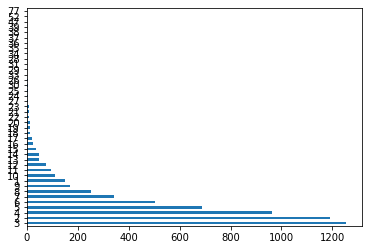

In [424]:
series = data.groupby("OpportunityId").OpportunityId.count()
series.sort_values(inplace=True)
series.head(3000)
series.value_counts().plot(kind = 'barh')
#opportunity_all = series["OpportunityId"]

In [425]:
print(series[-1])

77


In [426]:
all_opportunities = []
opp_longest = series[-1]

all_opor_e = []

#used to fulfill np.array to be with max length
example_arr = []

for index, row in data.iterrows():
    #print(row)
    all_opportunities.append(row["OpportunityId"])
all_opportunities = np.unique(all_opportunities)

for index, row in datae.iterrows():
    all_opor_e.append(row["OpportunityId"])
all_opor_e = np.unique(all_opor_e)
#print(all_opportunities)

In [ ]:
#for each opportunity and not id
#def
#here
#
#[license, service, upgrade, renewal, oem, global, new customer]
type_array = [0, 0, 0, 0, 0, 0, 0]
############
all_types = np.unique(data["Type"])



############



In [442]:
all_opportunities_array = []
final_probability_array = []

for opportunity in all_opportunities:
    opp_id = opportunity
    specific_opportinity = data.loc[(data.OpportunityId == opp_id)]

    specific_opportinity = specific_opportinity.sort_values(by="CreatedDateForInsert", ascending=True)

    start_date = specific_opportinity.loc[specific_opportinity.index[0], "CreatedDate"]
    start_date = datetime.strptime(start_date, '%m/%d/%Y %H:%M')

    res_arr = []
    time_filler = []
    arr = []
    i = 0
    for current in specific_opportinity["CreatedDateForInsert"]:
        current_date = datetime.strptime(current, '%m/%d/%Y %H:%M')
        res_arr.append(int((current_date - start_date).days))
        if i == 0:
            arr.append(int((current_date - start_date).days))
            i+=1
        else:
            arr.append(int((current_date - start_date).days) - arr[i-1])
            i+=1

        time_filler = np.ones(specific_opportinity.count) * 0.0
        arr_temp = np.append(arr,time_filler)

        specific_opportinity = specific_opportinity.loc[:, ["Amount", "Probability"]]
        specific_opportinity.insert(2, "Duration", res_arr)
        specific_opportinity.insert(3, "DeltaDuration", arr)
        final_probability = specific_opportinity.iloc[-1, specific_opportinity.columns.get_loc('Probability')]
        final_probability_array.append(final_probability)
        #print(final_probability)
        opp_array = np.array(specific_opportinity.iloc[-80:]).flatten()
        #print(opp_array)
        padding = np.ones(100) * 0.0
        op_ar_new = np.append(padding,opp_array)
        opp_array = op_ar_new[-80:]
        all_opportunities_array.append(opp_array)
        i+=1



all_opp_e_f = []
fl_prob_e_f = []

for opportunity in all_opor_e:
    opp_id = opportunity
    specific_opportinity = datae.loc[(datae.OpportunityId == opp_id)]

    specific_opportinity = specific_opportinity.sort_values(by="CreatedDateForInsert", ascending=True)

    start_date = specific_opportinity.loc[specific_opportinity.index[0], "CreatedDate"]
    start_date = datetime.strptime(start_date, '%m/%d/%Y %H:%M')

    res_arr = []
    arr = []
    i = 0
    for current in specific_opportinity["CreatedDateForInsert"]:
        current_date = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
        res_arr.append(int((current_date - start_date).days))
        if i == 0:
            arr.append(int((current_date - start_date).days))
            i+=1
        else:
            arr.append(int((current_date - start_date).days) - arr[i-1])
            i+=1

    specific_opportinity = specific_opportinity.loc[:, ["Amount", "Probability"]]
    specific_opportinity.insert(2, "Duration", res_arr)
    specific_opportinity.insert(3, "DeltaDuration", arr)
    final_probability = specific_opportinity.iloc[-1, specific_opportinity.columns.get_loc('Probability')]
    fl_prob_e_f.append(final_probability)

    opp_array = np.array(specific_opportinity.iloc[-20:]).flatten()

    padding = np.ones(100) * 0.0
    op_ar_new = np.append(padding,opp_array)
    opp_array = op_ar_new[-80:]
    all_opp_e_f.append(opp_array)



ValueError: Length of values (1) does not match length of index (2)

In [428]:
all_opportunities_array1 = np.asarray(all_opportunities_array)
final_probability_array1 = np.asarray(final_probability_array)

all_opor_e_f1 = np.asarray(all_opp_e_f)
fl_prob_e_f1 = np.asarray(fl_prob_e_f)

In [429]:
print(all_opportunities_array1[0])
print(all_opor_e_f1)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 100.   0.   0.   0.   0.  88.  88.]
[[   0.    0.    0. ...    0.   35.   14.]
 [   0.    0.    0. ...    0. 2169. 2124.]
 [   0.    0.    0. ...    0.  113.   12.]
 ...
 [   0.    0.    0. ...    0.   40.   40.]
 [   0.    0.    0. ...    0.  647.  647.]
 [   0.    0.    0. ...    0.  616.  616.]]


In [439]:
def base_model():
  inputs = tf.keras.Input(shape=(80,))
  x = tf.keras.layers.Dense(32, activation='relu')(inputs)
  x = tf.keras.layers.Dense(32, activation='relu')(x)
  outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
model = base_model()
model.compile(optimizer=optimizer, loss=loss_object, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 80)]              0         
                                                                 
 dense_51 (Dense)            (None, 32)                2592      
                                                                 
 dense_52 (Dense)            (None, 32)                1056      
                                                                 
 dense_53 (Dense)            (None, 101)               3333      
                                                                 
Total params: 6,981
Trainable params: 6,981
Non-trainable params: 0
_________________________________________________________________


In [431]:
def train_step(x, y):
  with tf.GradientTape() as tape:
    pred = model(x)
    loss = model.compiled_loss(y, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return tf.linalg.global_norm(gradients)

In [432]:

def create_generator(list_of_arrays):
    for i in list_of_arrays:
        yield i


In [433]:
dataset_opport = tf.data.Dataset.from_generator(lambda: create_generator(all_opportunities_array1),output_types= tf.int32, output_shapes=(80,))
dataset_marks = tf.data.Dataset.from_generator(lambda: final_probability_array1,output_types= tf.int32, output_shapes=())

dataset_test27 = tf.data.Dataset.zip((dataset_opport, dataset_marks)).batch(1)

dataset_opport_e = tf.data.Dataset.from_generator(lambda: create_generator(all_opor_e_f1),output_types= tf.int32, output_shapes=(80,))
dataset_marks_e = tf.data.Dataset.from_generator(lambda: fl_prob_e_f1,output_types= tf.int32, output_shapes=())

dataset_test27_e = tf.data.Dataset.zip((dataset_opport_e, dataset_marks_e)).batch(1)

In [434]:
print(dataset_test27)
print(dataset_test27_e)

<BatchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [435]:
print(len(list(dataset_test27)))
print(len(list(dataset_test27_e)))

for x,y in dataset_test27.take(1):
  print(x)
  print(y)

print(dataset_test27.take(1))
print(dataset_test27_e.take(1))


6065
926
tf.Tensor(
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 100   0   0   0   0  88  88]], shape=(1, 80), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
<TakeDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [440]:
from tqdm import tqdm
epoch_num = 5
grad_norm = []
for epoch in range(epoch_num):
  for step, (x,y) in enumerate(tqdm(dataset_test27)):
    grad_norm.append(train_step(x,y))

  loss, acc = model.evaluate(dataset_test27_e)
  print("validation loss = {}, accuracy = {}:".format(loss, acc))

6065it [00:57, 104.99it/s]


926/926 [==============================] - 1s 1ms/step - loss: 1.8365 - root_mean_squared_error: 71.6044
validation loss = 1.8364754915237427, accuracy = 71.60444641113281:


6065it [01:01, 98.55it/s] 


926/926 [==============================] - 1s 1ms/step - loss: 1.8372 - root_mean_squared_error: 71.6044
validation loss = 1.8371754884719849, accuracy = 71.60444641113281:


6065it [01:08, 88.58it/s] 

      1/Unknown - 0s 59ms/step - loss: 0.1532 - root_mean_squared_error: 0.0857

926/926 [==============================] - 1s 1ms/step - loss: 1.8372 - root_mean_squared_error: 71.6044
validation loss = 1.837174415588379, accuracy = 71.60444641113281:


6065it [00:59, 101.20it/s]

      1/Unknown - 0s 61ms/step - loss: 0.1532 - root_mean_squared_error: 0.0857

926/926 [==============================] - 1s 1ms/step - loss: 1.8372 - root_mean_squared_error: 71.6044
validation loss = 1.837174415588379, accuracy = 71.60444641113281:


6065it [00:55, 108.55it/s]

     47/Unknown - 0s 1ms/step - loss: 1.1403 - root_mean_squared_error: 63.5748

926/926 [==============================] - 1s 1ms/step - loss: 1.8372 - root_mean_squared_error: 71.6044
validation loss = 1.837174415588379, accuracy = 71.60444641113281:


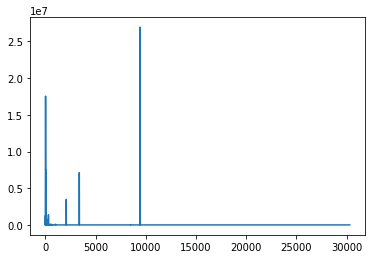

In [437]:
from matplotlib import rcParams
rcParams['ytick.labelleft'] = True
plt.plot(grad_norm)

